## Train the VAE

You must first train the VAE, which can be done using this [colab](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/vae.ipynb#scrollTo=3yM4yWXEO5RT) from Keras.

We assume your model is already trained and saved with e.g.:

    vae.decoder.save("vae_decoder")
    

## Load the model

You can find the trained version of the model used in this notebook here.
Download it and add it to your notebook's path.

In [1]:
from tensorflow import keras
import numpy as np
import json

vae_decoder = keras.models.load_model('vae_decoder')

/Users/jeremypinto/opt/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
2022-10-24 00:17:52.755600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-24 00:17:52.755719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


## Display a grid of sampled digits

We will use the grid to find the position of our digits in space.

1/1 [==============================] - 0s 9ms/step


2022-10-24 00:17:53.497772: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-24 00:17:53.545647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


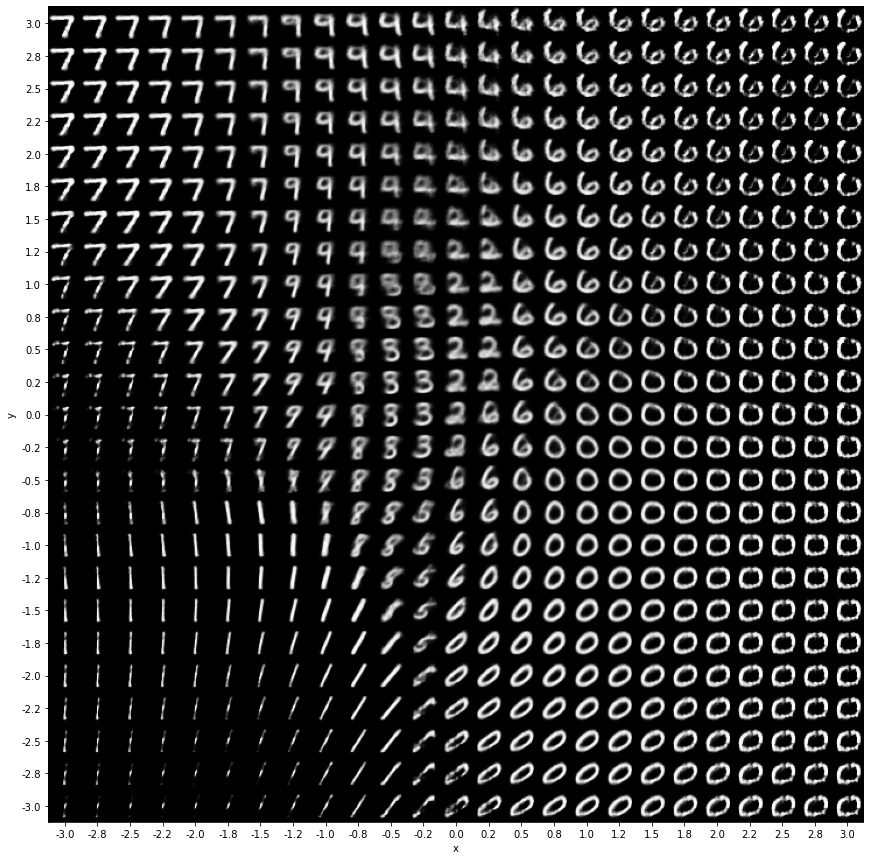

In [2]:
import matplotlib.pyplot as plt


def plot_latent_space(vae_decoder, n=30, scale=3, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae_decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae_decoder, n=25, scale=3)

In [3]:
def interp(a, b, step=20):
    x0, y0 = a
    x1, y1 = b
    grid_x = np.linspace(x0, x1, step)
    grid_y = np.linspace(y0, y1, step)
    return grid_x, grid_y

def normalize(arr):
    """Make array in range [0, 255]"""
    norm = (arr - np.min(arr)) / np.max(arr) * 255
    return norm.astype("uint8")

def traverse_latent_space(a, b, vae_decoder, step, digit_size=28):
    frames = []

    grid_x, grid_y = interp(a, b, step=step)
    for xi, yi in zip(grid_x, grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        frames.append(normalize(digit))
        
    return frames
    
    
def pad_frames(frames, n_frames=30):
    """Pad the first 10 and last 10 frames with first and last digit, respectively.
    
    Each transition will be 1 second at 30 fps, with only 10 frames of actual transition.
    """
    pad_frames = np.zeros((n_frames, 28, 28))
    pad_frames[:10, :, :] = frames[0]
    pad_frames[10:20, :, :] = frames
    pad_frames[20:30, :, :] = frames[-1]
    
    return pad_frames

def save_frames(frames, count):
    """Save images to disk. (useful for debugging)"""
    for frame in frames:
        plt.figure()
        plt.imshow(frame, cmap="gray")
        plt.savefig(f"images/fig_{count:003d}.png")
        plt.close()
        
        count += 1
        
    return count


def generate_frames_from_coords(coords, fname):
    coords.append(coords[0]) # loop back around to the first digit

    step = 10
    digit_size = 28

    all_frames = []
    for a, b in zip(coords, coords[1:]):
        frames = traverse_latent_space(a, b, vae_decoder, step)
        frames = pad_frames(frames)
        all_frames.append(frames)

    frames_list = [f.tolist() for f in all_frames]
    
    # save to json for javascript
    with open(fname, "w") as f:
        json.dump(frames_list, f, indent=2)
        
    return all_frames

In [4]:
import json

# Generate 0-9 digits
coords = [
    (1.3, -1.7), # 0
    (-1.3, -1.2), # 1
    (0.0, 0.0), # 2
    (-0.2, 0.0), # 3
    (0.0, 2.8), # 4
    (-0.2, -1.5), # 5
    (0.2, -0.8), # 6
    (-1.5, 1.0), # 7
    (-0.8, -0.8), # 8
    (-1.2, 0.8),  # 9
]

# Generate 0-9 digits (minutes + seconds unit)
frames = generate_frames_from_coords(coords, "0-9-mnist-vae.json")

# Generate 0-5 digits (minutes + seconds tens)
frames = generate_frames_from_coords(coords[0:6], "0-5-mnist-vae.json")

# Generate 0-4 digits (hours unit, 24h format)
frames = generate_frames_from_coords(coords[0:5], "0-4-mnist-vae.json")

# Generate 0-2 digits (hours tens, 24h format)
frames = generate_frames_from_coords(coords[0:3], "0-2-mnist-vae.json")

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


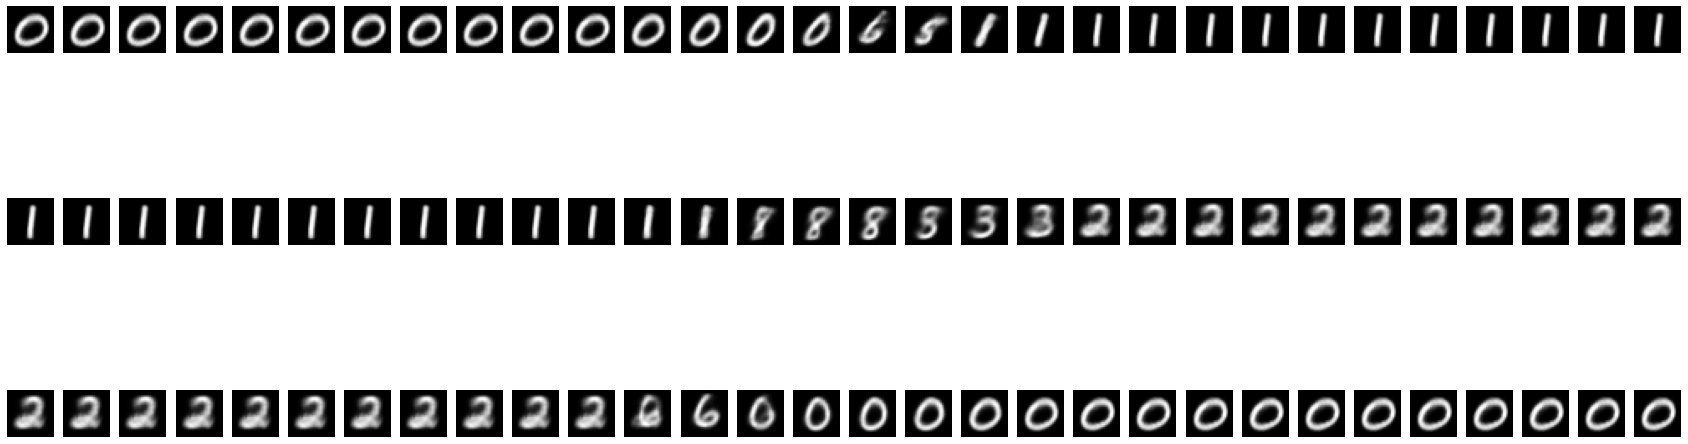

In [5]:
# plot the last generated frames
# Each row shows how the digits will end up morphing 
# Here, we show digits 0-2 in a loop

fig, axs = plt.subplots(len(frames), 30,  figsize=(30, 10))
for digit_idx, digit_frames in enumerate(frames):
    for frame_idx, frame in enumerate(digit_frames):
        ax = axs[digit_idx][frame_idx]
        ax.set_axis_off()
        ax.imshow(frame, cmap="gray")